In [7]:
import torch.nn as nn
import torch
import numpy as np
from matplotlib import pyplot as plt
from torch.utils.data import Dataset, DataLoader
import schedulefree
import nibabel as nib
from scipy.ndimage import gaussian_filter
from skimage.measure import label
from skimage import measure
from skimage.measure import regionprops
from scipy.ndimage import distance_transform_edt
from patchify import patchify


In [8]:
torch.cuda.is_available()

True

In [252]:
from torchvision.transforms import v2


def calculate_padding(in_size):
    pad = (32 - (in_size%32))
    if pad == 32:
        pad = 0
    return int(np.ceil(pad/2)), int(np.floor(pad/2))

class FiberData(Dataset):
    def __init__(self, inputs, labels, transforms = None):
        self.inputs = inputs
        self.labels = labels
        self.transforms = transforms
        # print(f"{len(inputs)}")
        # print(f"{inputs.shape}")
    def __len__(self):
        # return len(self.labels)
        _, length, _ = self.inputs.shape
        return length
    def __getitem__(self, idx):
        s1, s2 = self.inputs[:,idx,:].shape
        # print(f"{s1=}, {s2=}")
        input = self.inputs[:,idx,:]
        label = self.labels[:,idx,:]
        
        p1 = calculate_padding(s1)
        p2 = calculate_padding(s2)

        input = np.pad(input, (p1, p2), mode="constant")
        label = np.pad(label, (p1, p2), mode="constant")

        # input = self.inputs[:(s1//32)*32, :(s2//32)*32, idx]
        # label = self.labels[:(s1//32)*32, :(s2//32)*32, idx]
        # label = gaussian_filter(label, 100)
        input = np.expand_dims(input, 0)
        label = np.expand_dims(label, 0)
        # print(f"{input.shape=}, {label.shape=}")
        
        # label = (label - np.min(label)) /(np.max(label)-np.min(label))
        label = torch.from_numpy(np.array(label)).cuda()
        
        if self.transforms:
            input, label = self.transforms(input, label)
        input = torch.from_numpy(np.array(input)).cuda()
        return input.float(), label.float()


def get_nii_array(path):
    img = nib.load(path)
    img = np.array(img.dataobj).astype(np.float32)
    return img

train_augments =  v2.Compose([
    v2.RandomHorizontalFlip(p=0.5),
    v2.RandomVerticalFlip(p=0.5),
    v2.RandomAffine(degrees=0, scale=(1, 1.2))
])

In [10]:
np.floor(30//2)

15.0

In [261]:
# model = ResUnetPlusPlus(1)
# model.cuda()
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.encoders import get_preprocessing_fn
# optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

model = smp.UnetPlusPlus(
    encoder_name="resnet34",        # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
    encoder_weights="imagenet",     # use `imagenet` pre-trained weights for encoder initialization
    in_channels=1,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
    classes=1,                      # model output channels (number of classes in your dataset)
)


model.cuda()
# # create segmentation model with pretrained encoder
# model = smp.FPN(
#     encoder_name=ENCODER, 
#     encoder_weights=ENCODER_WEIGHTS, 
#     classes=len(CLASSES), 
#     activation=ACTIVATION,
# )


# optimizer = schedulefree.AdamWScheduleFree(model.parameters(), lr=0.00001)
optimizer = schedulefree.AdamWScheduleFree(model.parameters(), lr=0.0001)
loss_fn = torch.nn.MSELoss()
epoch_items_metrics = []  

# for step, (batch_im_patches, batch_fg_patches,
#            batch_bg_patches, batch_ignore_masks,
#            batch_seg_patches, batch_classes) in enumerate(loader):


In [230]:
print(len(val_dataset), len(train_dataset))

170 340


In [401]:
input = get_nii_array("im02.nii.gz")
print(f"image shape {input.shape=}")
label = get_nii_array("im59_labels.nii.gz")
_, a2, _ = input.shape

# 45 % test, 30 % val and 25 % test
val_idx = int(np.floor(a2*0.50))
test_idx = int(val_idx+np.floor(a2*0.25))
train_input = input[:, :val_idx, :]
train_label = label[:, :val_idx, :]
val_input = input[:, val_idx:test_idx, :]
val_label = label[:, val_idx:test_idx, :]
test_input = input[:, test_idx: ,:]
test_label = label[:, test_idx: ,:]

all_labels = label


image shape input.shape=(1376, 681, 298)


In [428]:
print(val_input.shape)
print(test_input.shape)



(1376, 170, 298)
(1376, 171, 298)


In [336]:
# plt.figure(figsize=(20,20))
# plt.imshow(gaussian_filter(train_label[:,:,30], 100))
from scipy.ndimage import distance_transform_edt
from skimage.measure import label

# gaus_train_label = np.zeros(train_label.shape)
# for i in range(train_label.shape[2]):
#     gaus_train_label[:, :, i] = gaussian_filter(train_label[:,:,i], 100)

# gaus_val_label = np.zeros(val_label.shape)
# for i in range(val_label.shape[2]):
#     gaus_val_label[:, :, i] = gaussian_filter(val_label[:,:,i], 100)


def transform_labels_to_density_map_2D(labels):
    labels_seg = label(labels)
    props = regionprops(np.array(labels_seg))
    gt = np.ones(labels_seg.shape)
    for p in props:
        c = np.round(np.array(p.centroid)).astype(int)
        gt[c[0], c[1]] = 0
    return distance_transform_edt(gt), len(props)

train_nums = []
train_sum = 0
edt_train_label = np.zeros(train_label.shape)
for i in range(train_label.shape[1]):
    transformed, num = transform_labels_to_density_map_2D(train_label[:,i,:])
    train_sum += num
    train_nums.append(num)
    edt_train_label[:, i, :] = transformed
print(train_sum/train_label.shape[1]) 

all_nums = []
all_sum = 0
edt_test_label = np.zeros(test_label.shape)
for i in range(all_labels.shape[1]):
    transformed, num = transform_labels_to_density_map_2D(test_label[:,i,:])
    all_sum += num
    all_nums.append(num)
    edt_train_label[:, i, :] = transformed
print(train_sum/train_label.shape[1]) 


val_nums = []
val_sum = 0
edt_val_label = np.zeros(val_label.shape)
for i in range(val_label.shape[1]):
    # edt_val_label[:, :, i] =  distance_transform_edt(np.invert(val_label[:,:,i].astype(bool)))
    transformed, num = transform_labels_to_density_map_2D(val_label[:,i,:])
    val_nums.append(num)
    val_sum += num
    edt_val_label[:, i, :] = transformed

print(val_sum/val_label.shape[1])


13.802941176470588
13.802941176470588
39.83529411764706


(20.944199706314244, 14.289840079547103)


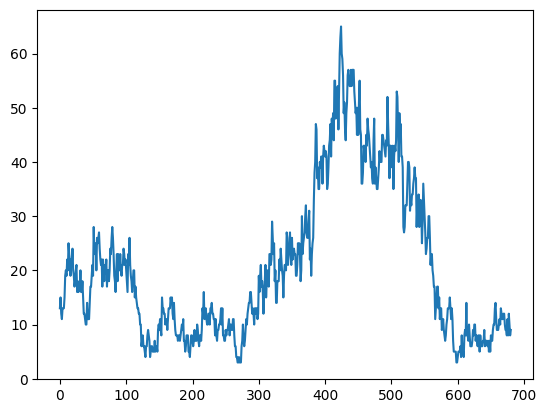

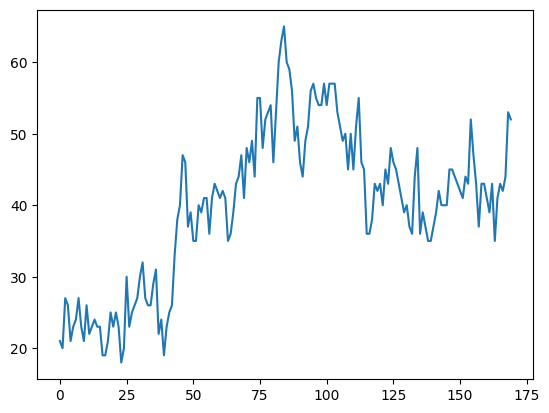

In [339]:
plt.plot(all_nums)
print(f"{np.mean(all_nums), np.std(all_nums)}")
plt.show()
plt.plot(val_nums)

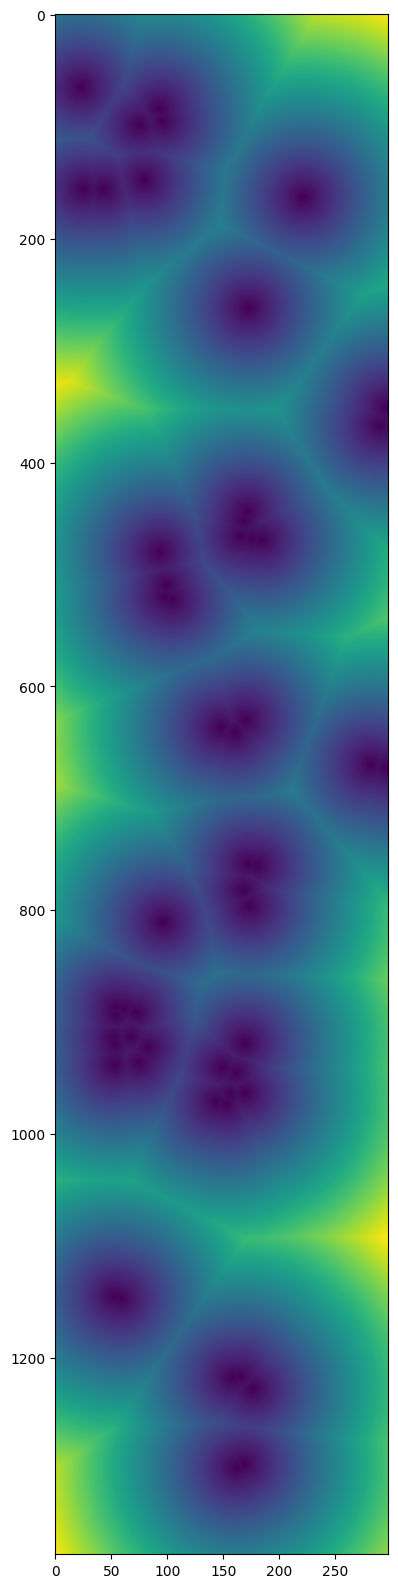

In [119]:
plt.figure(figsize=(20,20))
plt.imshow(edt_val_label[:,100,:])

In [403]:
train_dataset = FiberData(train_input, edt_train_label)
train_dataloader = DataLoader(train_dataset, batch_size=5, shuffle=True)

val_dataset = FiberData(val_input, edt_val_label)
val_dataloader = DataLoader(val_dataset, batch_size=5, shuffle=True)

test_dataset = FiberData(test_input, edt_val_label)
test_dataloader = DataLoader(test_dataset, batch_size=5, shuffle=False)

In [246]:
for param in model.parameters():
    if not (param.requires_grad):
        "not"

In [262]:



def train_epoch():
    loss_sum = 0
    losses = []
    model.train()
    num_batches = 0
    torch.set_grad_enabled(True)
    #for step, (input, label) in enumerate(zip(inputs, labels)):
    for step, (input, label) in enumerate(train_dataloader): 
        optimizer.zero_grad()
        # print(f"{input.shape=}")
        # print(f"{input.shape=}")
        outputs = model(input)
        # print(outputs.shape)

        loss = loss_fn(outputs, label)
        loss_sum += loss.item()
        losses.append(loss.item())
        # epoch_items_metrics += batch_items_metrics 
        # loss_sum += batch_loss.item() # float
        # batch_loss.backward()
        loss.backward()
        optimizer.step()
        num_batches += 1
        
    # print(f"epoch train loss = {loss_sum/len(losses)}")
    

    return loss_sum/(num_batches)


best_v_loss = 100000

# input, label = next(iter(train_dataloader))
# input = input.cpu().detach().numpy()
# label = label.cpu().detach().numpy()

num_epochs = 200
train_losses = []
val_losses = []
for i in range(num_epochs):
    epoch_loss = train_epoch()
    train_losses.append(epoch_loss)
    # print(f"{i} : {epoch_loss=}")
    model.eval()
    v_loss_sum = 0
    num_batches = 0
    with torch.no_grad():
        for j, (v_input, v_label) in enumerate(val_dataloader):
            #?? why use enumerate?
            v_output = model(v_input)
            v_loss = loss_fn(v_output, v_label)
            v_loss_sum += v_loss.item()
            num_batches += 1
    # print(f"validation loss = {v_loss_sum/num_batches}")
    val_loss = v_loss_sum/num_batches
    print(f"epoch {i}: train = {epoch_loss}  val = {val_loss}")
    val_losses.append(val_loss)
    if v_loss_sum/num_batches < best_v_loss:
        model_path = '14'
        torch.save(model.state_dict(), model_path)
        best_v_loss = v_loss_sum/num_batches
        print("Best validation score!")
    print()
input, label = next(iter(train_dataloader))
output = model(input).cpu().detach().numpy()
label = label.cpu().detach().numpy()


epoch 0: train = 28105.529002470128  val = 17763.335219439337
Best validation score!

epoch 1: train = 27926.828031652112  val = 17743.15590533088
Best validation score!

epoch 2: train = 27852.033289292278  val = 17705.040125229778
Best validation score!

epoch 3: train = 27784.95219152114  val = 17726.18031939338

epoch 4: train = 27687.921616498163  val = 17738.713953354778

epoch 5: train = 27618.7590044807  val = 17736.51171875

epoch 6: train = 27551.61867388557  val = 17723.492130055147

epoch 7: train = 27483.55364631204  val = 17697.767520680147
Best validation score!

epoch 8: train = 27419.161039464612  val = 17641.131993910847
Best validation score!

epoch 9: train = 27349.701839671416  val = 17647.211684283087

epoch 10: train = 27273.948235006894  val = 17625.18505859375
Best validation score!

epoch 11: train = 27178.68699017693  val = 17615.390682444853
Best validation score!

epoch 12: train = 27089.01570398667  val = 17561.999540441175
Best validation score!

epoch 13

In [321]:
# model_path = '2D-lr0.00001-200epochs-noAug-edt'
# torch.save(model.state_dict(), model_path)

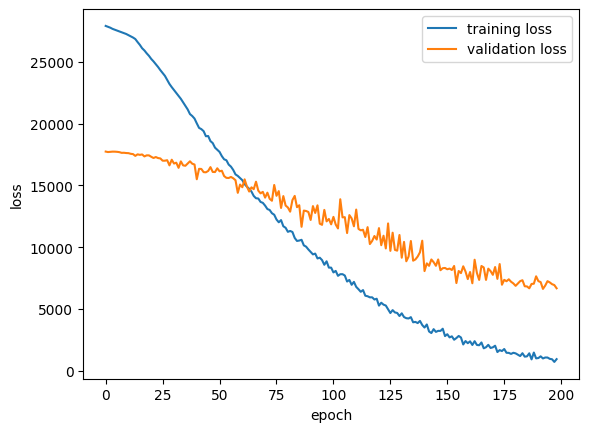

In [263]:
plt.figure()
plt.plot(train_losses[1:200], label="training loss")
plt.plot(val_losses[1:200], label="validation loss")
plt.legend()
plt.xlabel("epoch")
plt.ylabel("loss")
plt.show()


In [283]:
model.load_state_dict(torch.load('14'))
# torch.save(model.state_dict(), 'unet_100epochs_adamsf_default')

<All keys matched successfully>

(5, 1, 1376, 320)


/home/sofie/anaconda3/envs/rootEnv/lib/python3.10/site-packages/skimage/measure/_regionprops.py:594: RuntimeWarning: invalid value encountered in double_scalars
  tuple(M[_get_element(axis)] / M0 for axis in range(self._ndim)))


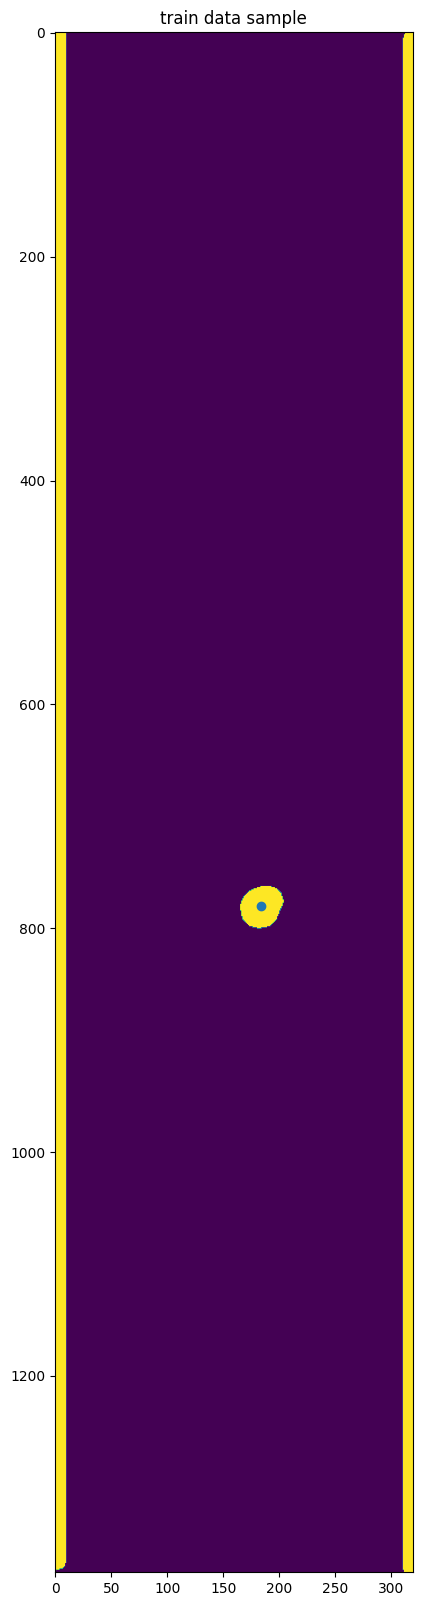

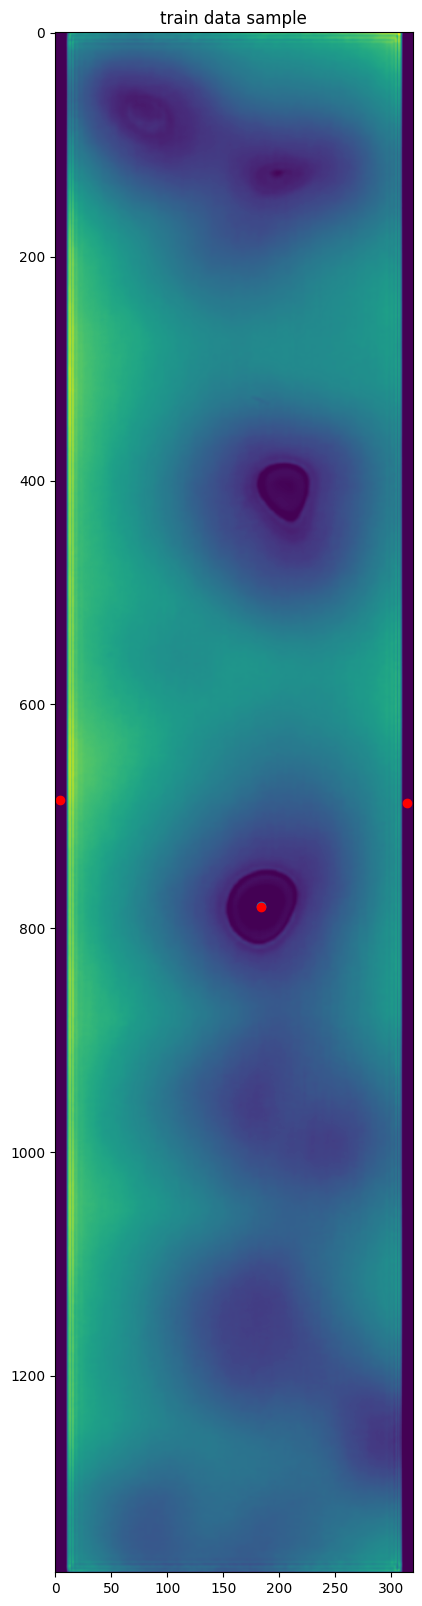

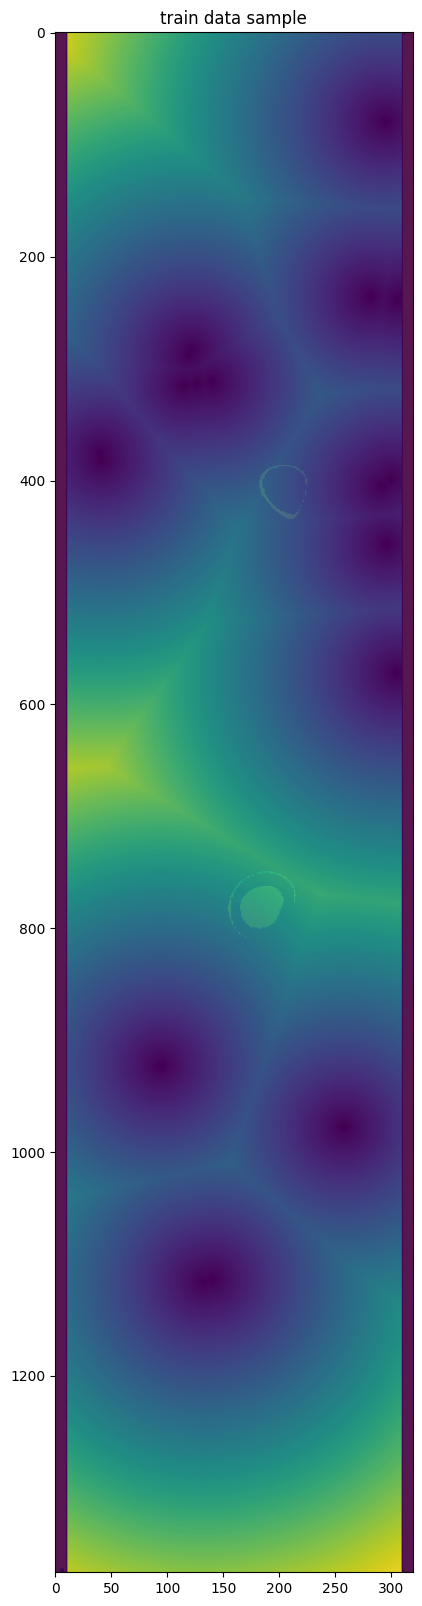

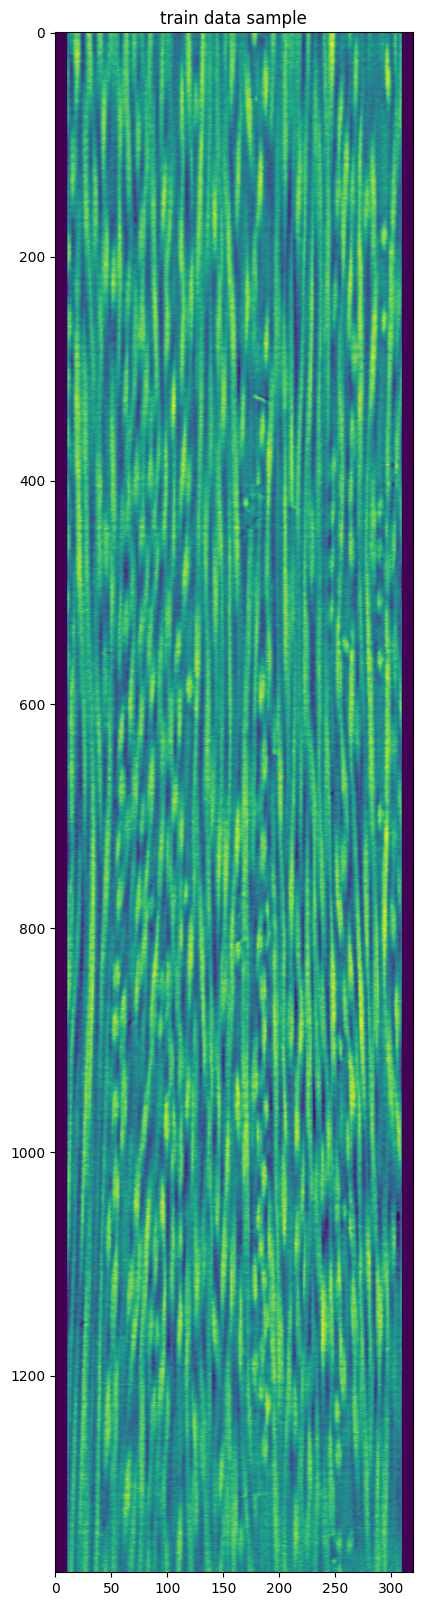

In [284]:
from skimage.morphology import binary_opening, disk, area_opening
from skimage.measure import regionprops, label
from skimage import filters
from skimage import feature
footprint= disk(5)

input, gt = next(iter(val_dataloader))
output = model(input).cpu().detach().numpy()
gt = gt.cpu().detach().numpy()
input = input.cpu()

print(output.shape)
plt.figure(figsize=(20,20))
plt.title("train data sample")
out_mask = output[2, 0, :, :]<1
out_mask = binary_opening(out_mask, footprint=footprint).astype(int)#, footprint=footprint)
out_labels = label(out_mask)
regions = (regionprops(out_labels, intensity_image=gt[2, 0, :, :]))
centroids_x = []
centroids_y = []
centroids_x2 = []
centroids_y2 = []
for r in regions:
    centroids_x.append(r.centroid_weighted[0])
    centroids_y.append(r.centroid_weighted[1])
    centroids_x2.append(r.centroid[0])
    centroids_y2.append(r.centroid[1])
    

plt.scatter(centroids_y, centroids_x)
plt.imshow(out_mask)
# plt.imshow(label[0, 0, :, :])
# plt.figure(figsize=(20,20))
# plt.title("train data sample")
# plt.imshow(feature.canny(output[2, 0, :, :]))
# plt.scatter(centroids_y, centroids_x)
# plt.scatter(centroids_y2, centroids_x2, c="r")
# plt.imshow(label[0, 0, :, :])
plt.show()
plt.figure(figsize=(20,20))
plt.title("train data sample")
plt.imshow((output[2, 0, :, :]))
plt.scatter(centroids_y, centroids_x)
plt.scatter(centroids_y2, centroids_x2, c="r")
# plt.imshow(label[0, 0, :, :])
plt.show()

plt.figure(figsize=(20,20))
plt.title("train data sample")
plt.imshow(gt[2, 0, :, :])
plt.imshow(output[2, 0, :, :]<1, alpha=0.1)
# plt.imshow(label[0, 0, :, :])
plt.show()

plt.figure(figsize=(20,20))
plt.title("train data sample")
plt.imshow(input[2, 0, :, :])
# plt.imshow(label[0, 0, :, :])
plt.show()


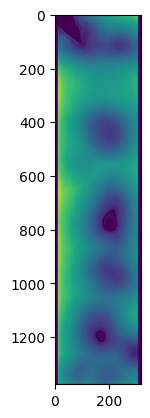

(5, 1, 1376, 320)


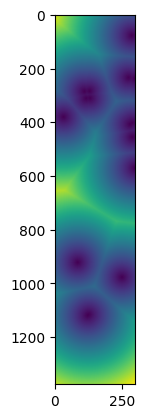

In [322]:
input, gt = next(iter(val_dataloader))
output = model(input).cpu().detach().numpy()
gt = gt.cpu().detach().numpy()
input = input.cpu()

plt.imshow(output[2][0])
plt.show()
plt.imshow(gt[2][0][:,11:-11])

print(output.shape)

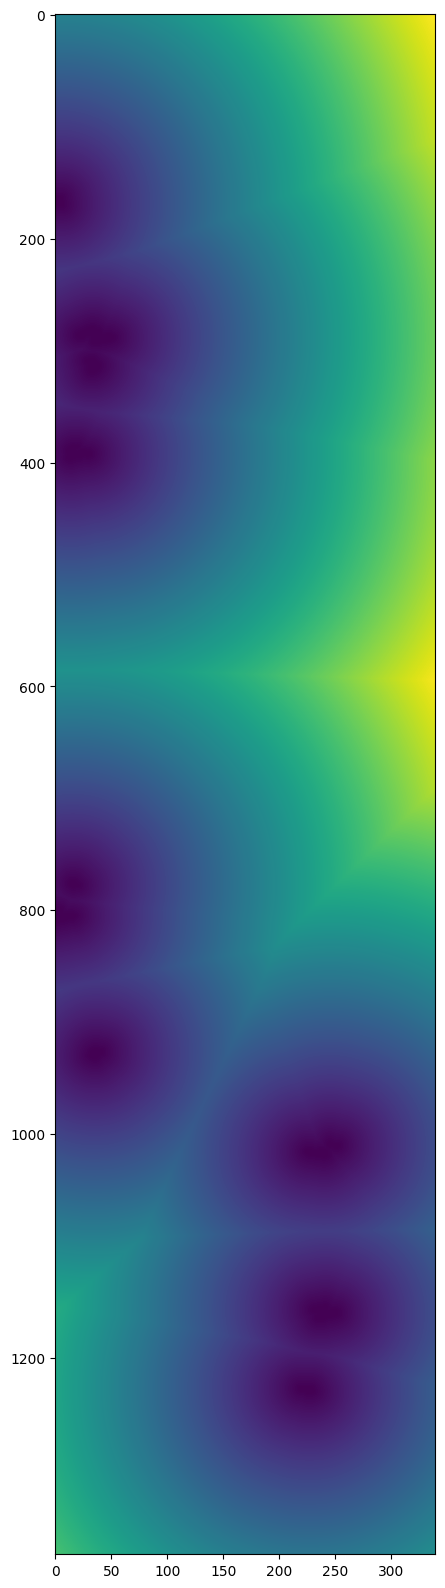

372.09138662430763 0.0


In [1089]:
from scipy.ndimage import distance_transform_edt
from skimage.segmentation import felzenszwalb
from skimage.segmentation import inverse_gaussian_gradient
from skimage.morphology import closing
edt = distance_transform_edt(np.invert(train_label[:,:,100].astype(bool)))
seg =(edt)
plt.figure(figsize=(20,20))
# plt.imshow((np.max(edt)-edt)>(np.max(edt)-5))
plt.imshow(seg)
# plt.imshow(train_label[:,:,100], alpha=0.6)
plt.show()
# label(train_label[:,:,100], return_num=True)
print(np.max(edt), np.min(edt))


In [472]:
full_out_flat = np.array([])
with torch.no_grad():
        for j, (v_input, v_label) in enumerate(val_dataloader):
            #?? why use enumerate?
            v_output = model(v_input)
            flat_output = np.ravel(v_output.cpu().detach().numpy())
            full_out_flat = np.concatenate((full_out_flat, flat_output))
            


In [342]:
from scipy.stats import norm
# np.mean(num_pr_slice)=13.751677852348994, np.std(num_pr_slice)=6.998951062606296

def make_random_guess(label_data):
    random_guesses = np.ones(label_data.shape)
    for i in range(label_data.shape[1]):
        num_fb = (norm.rvs(20.944199706314244, 14.289840079547103))
        rand_slice = np.ones((label_data.shape[0], label_data.shape[2]))
        for j in range(int(num_fb)):
            rand_slice[np.random.randint(label_data.shape[0]), np.random.randint(label_data.shape[2])] = 0
        rand_slice = distance_transform_edt(rand_slice)
        random_guesses[:,i,:] = rand_slice
    return random_guesses

def make_random_guess3D(num_fb, mode="val"):
    label = get_nii_array("im59_labels.nii.gz")
    random_guesses = np.ones(label.shape)
    # for i in range(val_label.shape[2]):
    #     num_fb = (norm.rvs( 13.75168, 6.99895))
    #     rand_slice = np.ones((val_label.shape[0], val_label.shape[1]))
    for j in range(int(num_fb)):
        random_guesses[np.random.randint(random_guesses.shape[0]), np.random.randint(random_guesses.shape[1]), np.random.randint(random_guesses.shape[2])] = 0
    guess_edt = distance_transform_edt(random_guesses)
    if mode == "train":
        guess_edt = guess_edt[:, :val_idx, :]
    elif mode == "val":
        guess_edt = guess_edt[:, val_idx:test_idx, :]
    guess_labels = patchify(guess_edt, (116, 116, 116), step=100)
    numd1, numd2, numd3, _,_,_ = guess_labels.shape
    guess_labels = guess_labels.reshape(numd1*numd2*numd3, 116, 116, 116)
    
    return guess_labels
        

    

In [424]:
# with torch.no_grad():
#     for j, (v_input, v_label) in enumerate(val_dataloader):
#         #?? why use enumerate?
#         v_output = model(v_input)
#         v_loss = loss_fn(v_output, v_label)
#         v_loss_sum += v_loss.item()
#         num_batches += 1
# # print(f"validation loss = {v_loss_sum/num_batches}")
# val_loss = v_loss_sum/num_batches
# print(f" val = {val_loss}")

# input = np.expand_dims(input, 0)


def get_model_pred(dataset, label_data):
    # print(len(dataset))
    # print(val_label.shape)
    # print(len(val_dataset))
    # print(val_dataset[0][0].shape)
    model_pred = np.zeros(label_data.shape)
    print(f"{label_data.shape}")
    for i in range(160, len(dataset)):
        p1, p2 = calculate_padding(label_data.shape[2])
        print(i)
        out = model(torch.unsqueeze(dataset[i][0], 0)).cpu().detach().numpy()
        # print(f"{out[0,0,:,11:-11].shape=}")
        model_pred[:,i,:] = out[0,0,:,p1:-p2]
        # plt.imshow(out[0,0,:,:], vmin=-1, vmax=25)
        # plt.show()
    # gt = val_dataset[i][1].cpu().detach().numpy()
    # plt.imshow(gt[0,:,:])
    # plt.title("gt")
    # plt.show()
# model_pred_val = get_model_pred(val_dataset, val_label)
print(len(test_dataset))
print(test_label.shape)
# model_pred_test = get_model_pred(test_dataset, test_label)
model_pred = np.zeros(test_label.shape)
model_pred[:,170,:]
print(test_dataset[170])

171
(1376, 171, 298)


IndexError: index 170 is out of bounds for axis 1 with size 170

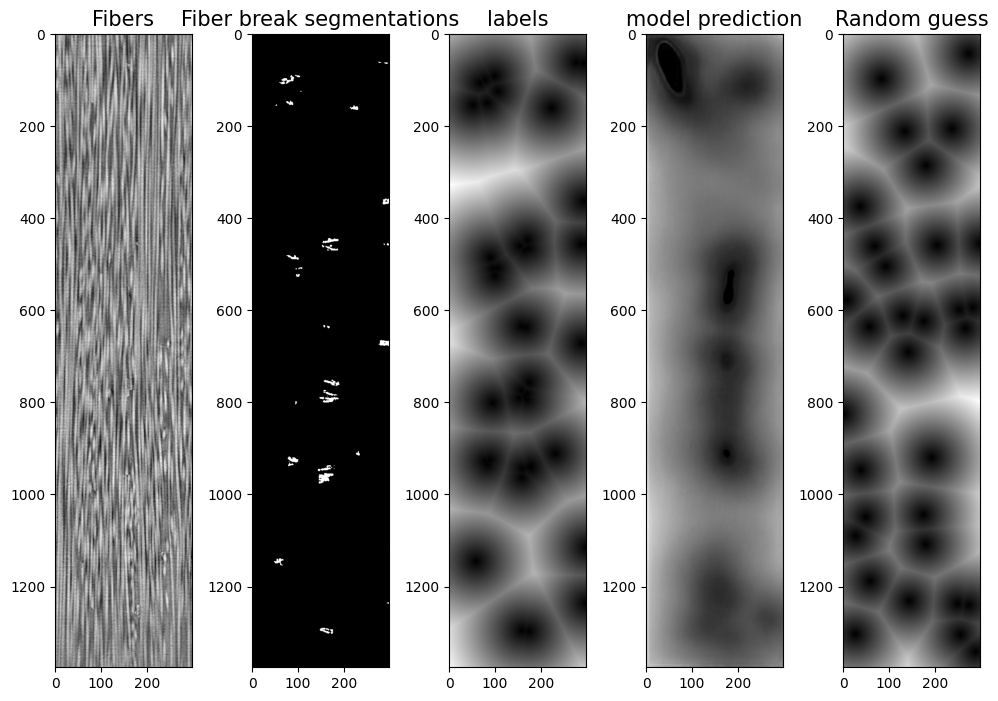

In [400]:
i = -60
random_guess = make_random_guess()
fig, (ax0, ax1, ax2, ax3, ax4) = plt.subplots(1, 5, figsize=(10,15))
ax0.set_title("Fibers", fontsize=15)
a0 = ax0.imshow(val_input[:,i,:],cmap='gray')
ax1.set_title("Fiber break segmentations", fontsize=15)
a1 = ax1.imshow(val_label[:,i,:],cmap='gray')
ax2.set_title("labels", fontsize=15)
a2 = ax2.imshow(edt_val_label[:,i,:], cmap='gray')
ax3.set_title("model prediction", fontsize=15)
a3 = ax3.imshow(model_pred_val[:,i,:], cmap='gray')
ax4.set_title("Random guess", fontsize=15)
a4 = ax4.imshow(random_guess[:,i,:], cmap='gray')
fig.tight_layout()
plt.show()

(1376, 170, 298)


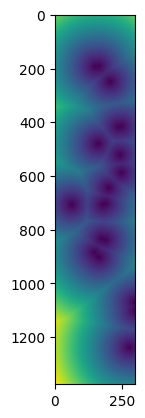

In [353]:
plt.imshow(edt_val_label[:,0,:])
print(edt_val_label[:,:].shape)

In [371]:
from skimage.metrics import mean_squared_error
print( mean_squared_error(edt_val_label, model_pred_val))
guess_scores = []
for i in range(25):
    random_guesses = make_random_guess()
    guess_score = mean_squared_error(edt_val_label, random_guesses)
    guess_scores.append(guess_score)
    # if guess_score > 300000:
    #     break

4185.242364163599


np.median(guess_score)=64429.82918968398, np.mean(guess_scores)=54095.58330491338, np.std(guess_scores)=11692.801519107328


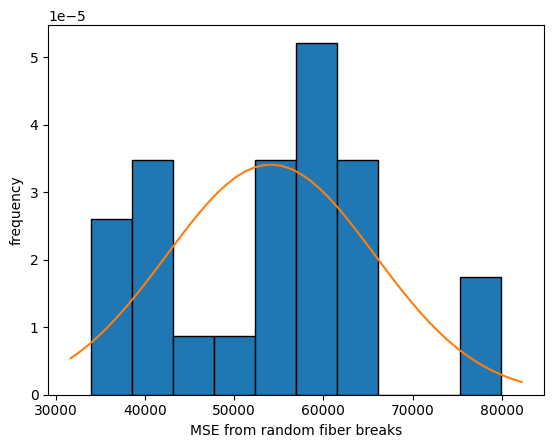

In [372]:
# guess_scores = np.array(guess_scores)
print(f"{np.median(guess_score)=}, {np.mean(guess_scores)=}, {np.std(guess_scores)=}")
plt.hist(guess_scores, bins=10, edgecolor="Black", density=True)
plt.xlabel("MSE from random fiber breaks")
plt.ylabel("frequency")
x_min, x_max = plt.xlim()
x = np.linspace(x_min, x_max)
y = norm.pdf(x, np.mean(guess_scores), np.std(guess_scores))
plt.plot(x, y)

In [326]:
sorted(guess_scores)

[39961.03395145859,
 42149.25989635431,
 44565.7910519523,
 45110.84734693867,
 48815.3716535806,
 49383.00419823444,
 49630.34116469837,
 49743.22089867539,
 50043.34123048855,
 52593.392374278774,
 52763.75875111457,
 52823.05412613975,
 52855.7130561458,
 54186.65578850813,
 54243.513561795735,
 54498.86449304412,
 54625.024694680134,
 54657.94042497292,
 56269.57409277957,
 57793.88448216603,
 59063.74648005786,
 61261.8892388624,
 61388.63518915504,
 61432.11231254002,
 65759.02298587041]

0.2108124535297975
0.4412225758424029


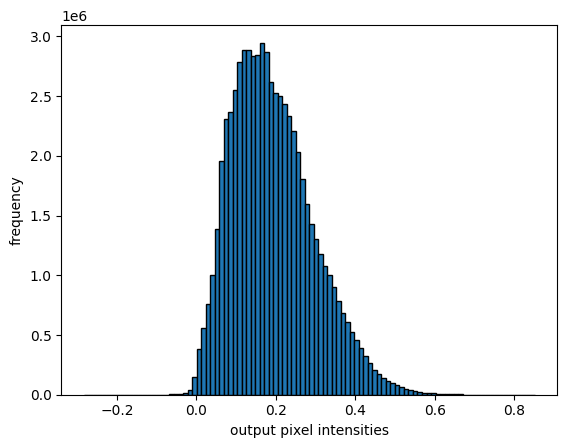

In [533]:
plt.hist(full_out_flat, bins=100, edgecolor="Black")
plt.xlabel("output pixel intensities")
plt.ylabel("frequency")
from skimage.filters import threshold_otsu, threshold_isodata, threshold_li, threshold_triangle
print(threshold_otsu(full_out_flat))
print(threshold_triangle(full_out_flat))


In [319]:
#count number of fiber breaks pr slice 2D
num_pr_slice = []
for i in range(train_label.shape[2]):
    label_i = label(train_label[:, :, i])
    props = regionprops(label_i)
    num_pr_slice.append(len(props))

for i in range(val_label.shape[2]):
    label_i = label(train_label[:, :, i])
    props = regionprops(label_i)
    num_pr_slice.append(len(props))



In [353]:
#count nr of fiber breaks pr patch 3D
label = get_nii_array("im59_labels.nii.gz")
patches = patchify(label, (116, 116, 116), step=100)
s1, s2, s3, s4, s5, s6 = patches.shape
patches = np.reshape(patches, (s1*s2*s3, s4, s5, s6))
print(f"{patches[0].shape}")
num_pr_patch = []
for i in range(len(patches)):
    label_i, num = measure.label(patches[i], return_num=True)
    num_pr_patch.append(num)

# for i in range(val_label.shape[2]):
#     label_i = label(train_label[:, :, i])
#     props = regionprops(label_i)
#     num_pr_slice.append(len(props))
print(len(patches), patches.shape)

(116, 116, 116)
156 (156, 116, 116, 116)


In [352]:
print(f"{np.median(num_pr_patch)=}, {np.mean(num_pr_patch)=}, {np.var(num_pr_patch)=}")
label_i, num = measure.label(label, return_num=True)
print(num)

np.median(num_pr_patch)=2.0, np.mean(num_pr_patch)=3.0961538461538463, np.var(num_pr_patch)=7.984344181459565
217


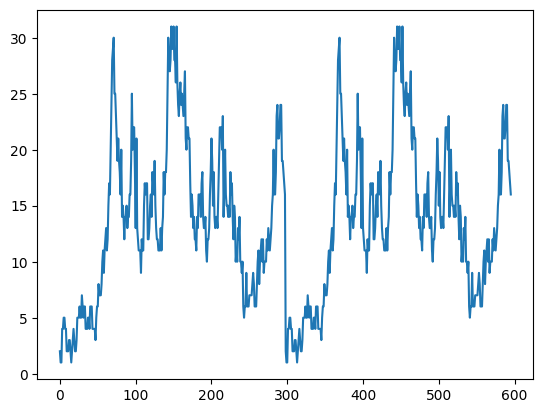

np.mean(num_pr_slice)=13.751677852348994, np.std(num_pr_slice)=6.998951062606296


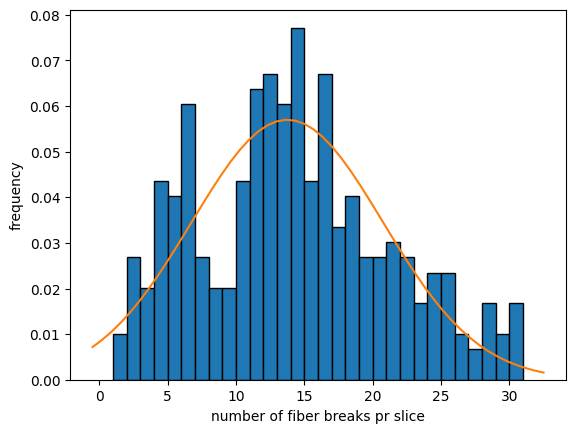

In [320]:
from scipy.stats import norm
plt.plot(num_pr_slice)
plt.show()
print(f"{np.mean(num_pr_slice)=}, {np.std(num_pr_slice)=}")

plt.hist(num_pr_slice, bins=30, edgecolor="Black", density=True)
plt.xlabel("number of fiber breaks pr slice")
plt.ylabel("frequency")
x_min, x_max = plt.xlim()
x = np.linspace(x_min, x_max)
y = norm.pdf(x, np.mean(num_pr_slice), np.std(num_pr_slice))
plt.plot(x, y)

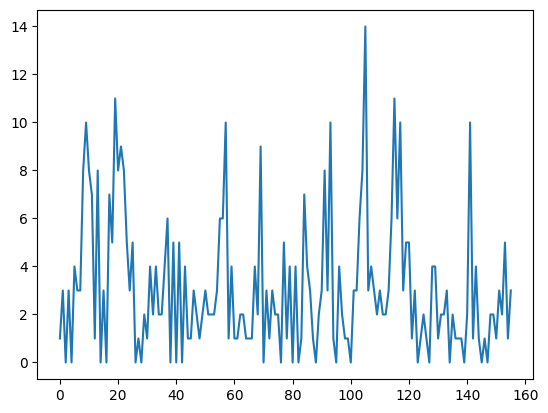

np.mean(num_pr_patch)=3.0961538461538463, np.std(num_pr_patch)=2.825658185531216


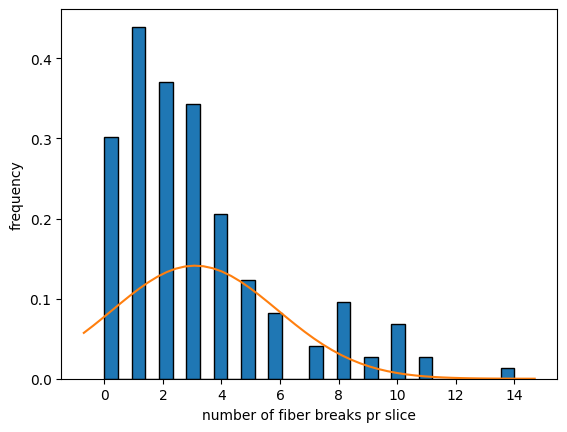

In [350]:
plt.plot(num_pr_patch)
plt.show()
print(f"{np.mean(num_pr_patch)=}, {np.std(num_pr_patch)=}")

plt.hist(num_pr_patch, bins=30, edgecolor="Black", density=True)
plt.xlabel("number of fiber breaks pr slice")
plt.ylabel("frequency")
x_min, x_max = plt.xlim()
x = np.linspace(x_min, x_max)
y = norm.pdf(x, np.mean(num_pr_patch), np.std(num_pr_patch))
plt.plot(x, y)